In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
# !pip3.8 install tensorflow-addons

In [3]:
import warnings
warnings.filterwarnings("ignore")

import importlib  
import unittest
import random
from copy import deepcopy
from time import time

import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.layers import Input, Dense, Layer, InputSpec, Lambda, Add, Multiply, LeakyReLU, ReLU
from tensorflow.keras import regularizers, activations, initializers, constraints, Sequential, layers, optimizers
from tensorflow.keras.regularizers import l1_l2 #l2, l1
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.constraints import UnitNorm, Constraint
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.utils import plot_model

from tensorboard.plugins.hparams import api as hp


from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Binarizer, OrdinalEncoder

import scipy.io as scio
from scipy.linalg import orth

import weightwatcher as ww

# from localfinlab.clustering import InfoMax
from localfinlab.clustering import *
import localfinlab as lfl

from localfinlab.utils import get_random_hash


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [197]:
model_identifier = get_random_hash()
matrix_identifier = 'mutual_info_matrix'

In [145]:
import sys
sys.path.append("/home/aaron/notebooks/test-strategy/thesis/sarmento-original-thesis/classes")

dp_foobar = importlib.import_module("class_DataProcessor")

series_analyser = lfl.pairs_trading_backtester.series_analyser.SeriesAnalyser()
data_processor = dp_foobar.DataProcessor()

# intraday
df_prices = pd.read_pickle('../sarmento-original-thesis/data/pickle/commodity_ETFs_from_2014_complete.pickle')

SPLIT_IDX = 2

splits = [ 
    [('01-01-2012', '31-12-2014'), ('01-01-2015', '31-12-2015'), '2014-01-01'],
    [('01-01-2013', '31-12-2015'), ('01-01-2016', '31-12-2016'), '2015-01-01'],
    [('01-01-2014', '31-12-2016'), ('01-01-2017', '31-12-2017'), '2016-01-01'] 
]

# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices, splits[SPLIT_IDX][0], splits[SPLIT_IDX][1], remove_nan=True)

df_train_returns = data_processor.get_return_series(df_prices_train)#.asfreq('B').dropna()
df_test_returns = data_processor.get_return_series(df_prices_test)#.asfreq('B').dropna()


Total of 116 tickers
Total of 116 tickers after removing tickers with Nan values


In [198]:

# load etf metadata
etfs, etfs_unique, tickers = data_processor.read_ticker_excel(path='../sarmento-original-thesis/data/commodity_ETFs_long_updated.xlsx')

# Convert string categorical set describing asset sectors/segments to integer.
enc = OrdinalEncoder()

sector_data_df = etfs_unique[etfs_unique['Ticker'].isin(df_train_returns.columns)]['Sector']

enc.fit(sector_data_df.astype(str).values.reshape(-1, 1))

sector_ground_truth = enc.transform(sector_data_df.astype(str).values.reshape(-1, 1)).reshape(-1)


segment_data_df = etfs_unique[etfs_unique['Ticker'].isin(df_train_returns.columns)]['Segment']

enc.fit(segment_data_df.astype(str).values.reshape(-1, 1))

segment_ground_truth = enc.transform(segment_data_df.astype(str).values.reshape(-1, 1)).reshape(-1)

In [199]:

scaler = StandardScaler()
scaler.fit(df_train_returns)

train_X = scaler.transform(df_train_returns)

refinement_X = scaler.transform(df_test_returns)

print('Data preprocessing has done!')

Data preprocessing has done!


In [200]:
class CustomCallback(Callback):
    
    def on_train_begin(self, logs=None):

        self.initial_model = deepcopy(self.model)

    def on_epoch_end(self, epoch, logs={}):
        
        watcher = ww.WeightWatcher(model=self.model, log_level=40)
        avgDelta, details = watcher.distances(self.initial_model, self.model)
        logs['distance'] = avgDelta

In [201]:
@tf.function
def train_step(x, y):
    
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
        
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_loss_tracker.update_state(y, logits)
    
    return loss_value

@tf.function
def test_step(x, y):
    
    val_logits = model(x, training=False)
    val_loss_tracker.update_state(y, val_logits)


In [202]:
INPUT_SHAPE = len(df_train_returns.columns)

# epochs = 1000
# batch_size = 42
# l2_reg = 0.177
# l1_reg = 0.05
# noise_factor = 0.493
# optimizer = Adam()
# verbose = False


epochs = 1000
batch_size = 74
l2_reg = 0.435
l1_reg = 0.05
noise_factor = 0.10
optimizer = RMSprop()
verbose = False


In [203]:
from time import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Layer, InputSpec, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

from tensorflow.keras.constraints import UnitNorm, Constraint

def func_api_get_autoencoder(dims, embedding_dim=10, act='relu', kernel_regularizer=None):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    x = Input(shape=(dims[0],), name='input')
    h = x

    if dims != 1:
        # internal layers in encoder
        for i in range(n_stacks):
            h = Dense(dims[i + 1], activation=act, kernel_regularizer=kernel_regularizer, name='encoder_%d' % i)(h)
            h = BatchNormalization()(h)

    # hidden layer # hidden layer, features are extracted from here
    h = Dense(embedding_dim, activation=act, kernel_regularizer=kernel_regularizer, name='embedding')(h)
    h = BatchNormalization()(h)

    y = h
    # internal layers in decoder
    for i in range(n_stacks, 0, -1):
        y = Dense(dims[i], activation=act, kernel_regularizer=kernel_regularizer, name='decoder_%d' % i)(y)
        y = BatchNormalization()(y)

    # output
    y = Dense(dims[0], activation=act, name='decoder_0')(y)

    return Model(inputs=x, outputs=y)


model = func_api_get_autoencoder([INPUT_SHAPE//1], act='relu', kernel_regularizer=l2(l2=l2_reg))

# model = tf.keras.Sequential([
#     InputLayer(input_shape=(INPUT_SHAPE,)),
#     Dense(150, activation=ReLU(), kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_regularization_weight_decay)),
#     Dense(70, activation=ReLU(), kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_regularization_weight_decay)),
#     Dense(10, activation=ReLU(), name="embedding"),# kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_regularization_weight_decay)),
#     Dense(70, activation=ReLU(), kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_regularization_weight_decay)),
#     Dense(150, activation=ReLU(), kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_regularization_weight_decay)),
#     Dense(INPUT_SHAPE, activation=ReLU(), name="final", kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_regularization_weight_decay))
# ])

model.summary()

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 116)]             0         
_________________________________________________________________
embedding (Dense)            (None, 10)                1170      
_________________________________________________________________
batch_normalization_15 (Batc (None, 10)                40        
_________________________________________________________________
decoder_0 (Dense)            (None, 116)               1276      
Total params: 2,486
Trainable params: 2,466
Non-trainable params: 20
_________________________________________________________________


# Mutual Information Preparation

In [204]:
from mlfinlab.codependence import (get_dependence_matrix, get_distance_matrix)

train_X_cov = pd.DataFrame(get_dependence_matrix(df_train_returns, dependence_method='mutual_information'))
refinement_X_cov = pd.DataFrame(get_dependence_matrix(df_test_returns, dependence_method='mutual_information')) 

cov_scaler = StandardScaler()
cov_scaler.fit(train_X_cov)

train_X_cov = pd.DataFrame(cov_scaler.transform(train_X_cov))
refinement_X_cov = pd.DataFrame(cov_scaler.transform(refinement_X_cov))

train_dataset = tf.data.Dataset.from_tensor_slices((train_X_cov, train_X_cov))
train_dataset = train_dataset.shuffle(buffer_size=25).batch(batch_size, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((refinement_X_cov, refinement_X_cov))
test_dataset = test_dataset.shuffle(buffer_size=25).batch(batch_size, drop_remainder=True)

# Covariance Preparation

In [205]:
# train_X_cov = pd.DataFrame(np.dot(df_train_returns.T, df_train_returns))
# refinement_X_cov = pd.DataFrame(np.dot(df_test_returns.T, df_test_returns)) 

# cov_scaler = StandardScaler()
# cov_scaler.fit(train_X_cov)

# train_X_cov = pd.DataFrame(cov_scaler.transform(train_X_cov))
# refinement_X_cov = pd.DataFrame(cov_scaler.transform(refinement_X_cov))

# train_dataset = tf.data.Dataset.from_tensor_slices((train_X_cov, train_X_cov))
# train_dataset = train_dataset.shuffle(buffer_size=25).batch(batch_size, drop_remainder=True)

# test_dataset = tf.data.Dataset.from_tensor_slices((refinement_X_cov, refinement_X_cov))
# test_dataset = test_dataset.shuffle(buffer_size=25).batch(batch_size, drop_remainder=True)

In [206]:

loss_fn = tf.keras.losses.MeanSquaredError('auto')

train_loss_tracker = tf.keras.metrics.MeanSquaredError('train_loss')
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name='val_loss')

_callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=100, restore_best_weights=True)]

callbacks = tf.keras.callbacks.CallbackList(_callbacks, add_history=True, model=model)

loss_per_epoch = []

logs = {}
callbacks.on_train_begin(logs=logs)

for epoch in range(epochs):
    callbacks.on_epoch_begin(epoch, logs=logs)
    
    if verbose:
        print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        # Add noise to the input to feed to Denoising encoder model.
        x_noisy_train = x_batch_train + noise_factor*tf.random.normal(shape=tf.shape(x_batch_train), mean=0.0, stddev=1.0, dtype=tf.float64) 
        x_noisy_train = tf.clip_by_value(x_noisy_train, 0.0, 1.0)
        
        loss_value = train_step(x_noisy_train, y_batch_train)

    # Display metrics at the end of each epoch.
    train_loss = train_loss_tracker.result()
    
    if verbose:
        print("Training acc over epoch: %.4f" % (float(train_loss),))

    # Reset training metrics at the end of each epoch
    train_loss_tracker.reset_states()           
    
    # Iterate over the batches of the dataset.
    for step, (x_batch_val, y_batch_val) in enumerate(test_dataset):

        # Add noise to the input to feed to Denoising encoder model.
        x_noisy_val = x_batch_val + noise_factor*tf.random.normal(shape=tf.shape(x_batch_val), mean=0.0, stddev=1.0, dtype=tf.float64) 
        x_noisy_val = tf.clip_by_value(x_noisy_val, 0.0, 1.0)

        test_step(x_noisy_val, y_batch_val)

    val_loss = val_loss_tracker.result()
    val_loss_tracker.reset_states()
    
    if verbose:
        print("Validation acc: %.4f" % (float(val_loss),))

    loss_per_epoch.append([train_loss.numpy(), val_loss.numpy()])
    
    logs['val_loss'] = val_loss
    
    callbacks.on_epoch_end(epoch, logs=logs)
    
    if model.stop_training:
        break
    
callbacks.on_train_end(logs=logs)


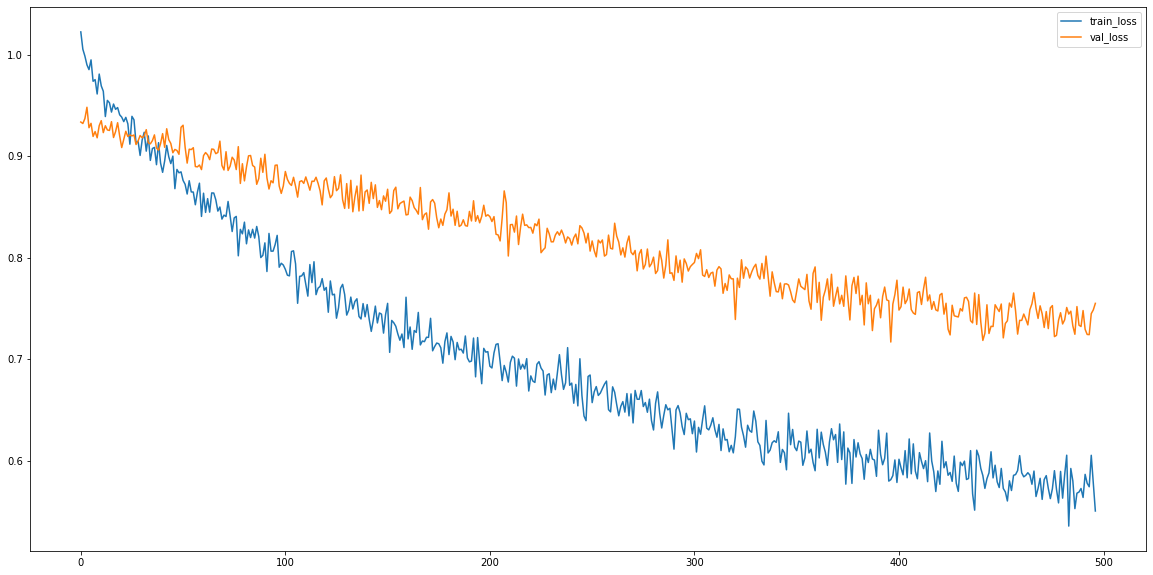

In [207]:
loss_per_epoch_df = pd.DataFrame(loss_per_epoch, columns=['train_loss', 'val_loss'])

plt.figure(figsize=(20, 10))
plt.plot(loss_per_epoch_df)
plt.legend(loss_per_epoch_df)

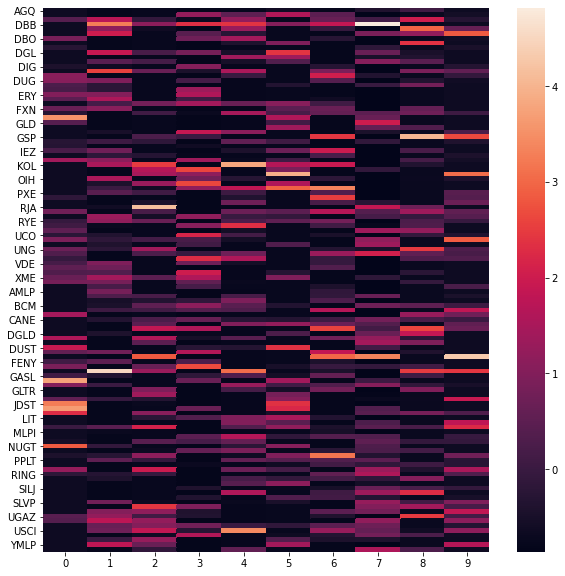

In [208]:
pre_train_feature_model = Model(inputs=model.input, outputs=model.get_layer('embedding').output)

pre_train_feats = pre_train_feature_model.predict(train_X_cov)

pre_train_clusterable_feature_df_scaler = StandardScaler()
pre_train_clusterable_feature_df_scaler.fit(pre_train_feats)

pre_train_feats_scaled = pre_train_clusterable_feature_df_scaler.transform(pre_train_feats)
    
pre_train_clusterable_feature_df = pd.DataFrame(pre_train_feats_scaled).T
pre_train_clusterable_feature_df.columns = df_train_returns.columns
pre_train_clusterable_feature_df = pre_train_clusterable_feature_df.T

tsne = TSNE(n_components=2, random_state=42)
flat_dim_data_df = pd.DataFrame(tsne.fit_transform(pre_train_clusterable_feature_df))

flat_dim_data_df.set_index(pre_train_clusterable_feature_df.index, inplace=True)

plt.figure(figsize=(10, 10))
sns.heatmap(pre_train_clusterable_feature_df)
plt.show()

In [209]:
model.save('./ae_exhaust/' + matrix_identifier + '/saved_models/' + str(SPLIT_IDX) + '/' + model_identifier + '.h5')
pre_train_clusterable_feature_df.to_csv('./ae_exhaust/' + matrix_identifier + '/embedding_sets/' + str(SPLIT_IDX) + '/' + model_identifier + '.csv')

# ######################################################

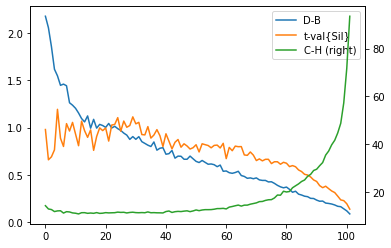

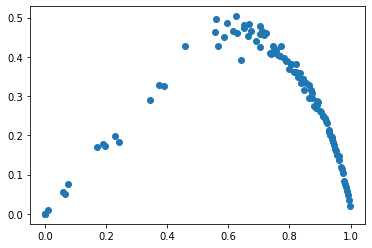

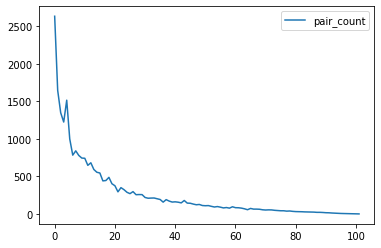

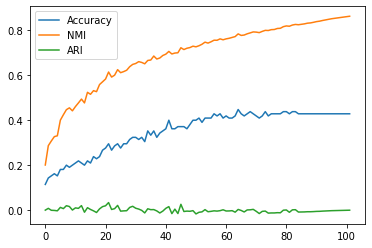

In [32]:
spectral_algo_args_template = {'n_clusters': range(3, INPUT_SHAPE, 1), 'eigen_tol': [1e-5], 'assign_labels': ['discretize']}
kmeans_algo_args_template = {'init':['k-means++'], 'n_clusters': range(3, INPUT_SHAPE, 1), 'n_init': [20]}
kmedoids_algo_args_template = {'init':['k-medoids++'], 'n_clusters': range(3, INPUT_SHAPE, 1)}
agglomerative_algo_args_template = {'n_clusters': range(3, INPUT_SHAPE, 1), 'linkage': ['ward', 'single', 'complete', 'average']}
optics_algo_args_template = {'min_samples': range(2, 6), 'metric': ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']}
dbscan_algo_args_template = {'min_samples': range(3, 7), 'metric': ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']}

optics_internal_df, optics_external_df = run_clustering_evaluation(pre_train_clusterable_feature_df, ground_truth=segment_ground_truth,
                                                                   algo_args={'kmeans':  permute_params(kmeans_algo_args_template)})
#                                                                                {'kmeans':  permute_params(kmeans_algo_args_template)}) 
#                                                                               'agglomerative': permute_params(agglomerative_algo_args_template),
#                                                                               'optics': permute_params(optics_algo_args_template)})

optics_internal_df['D-B'].plot(legend=True)
optics_internal_df['t-val{Sil}'].plot(legend=True)
optics_internal_df['C-H'].plot(secondary_y=True, legend=True)

plt.show()

plt.scatter(optics_internal_df['E[s]'], optics_internal_df['E[k_s]']) 

plt.show()

optics_internal_df['pair_count'].plot(legend=True)

plt.show()

optics_external_df.plot(legend=True)

{'init': 'k-means++', 'n_clusters': 40, 'n_init': 20}
Clusters discovered: 40
Pairs to evaluate: 144


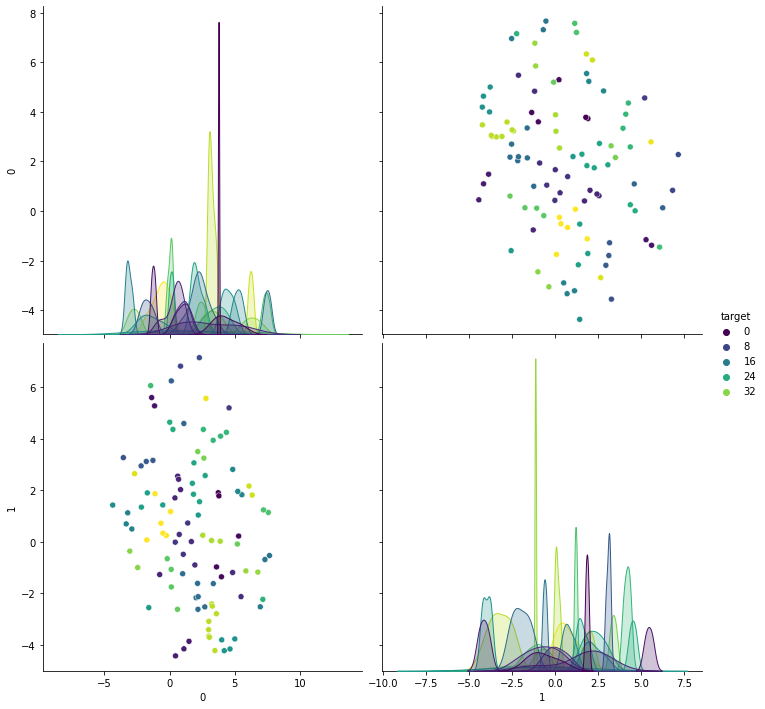

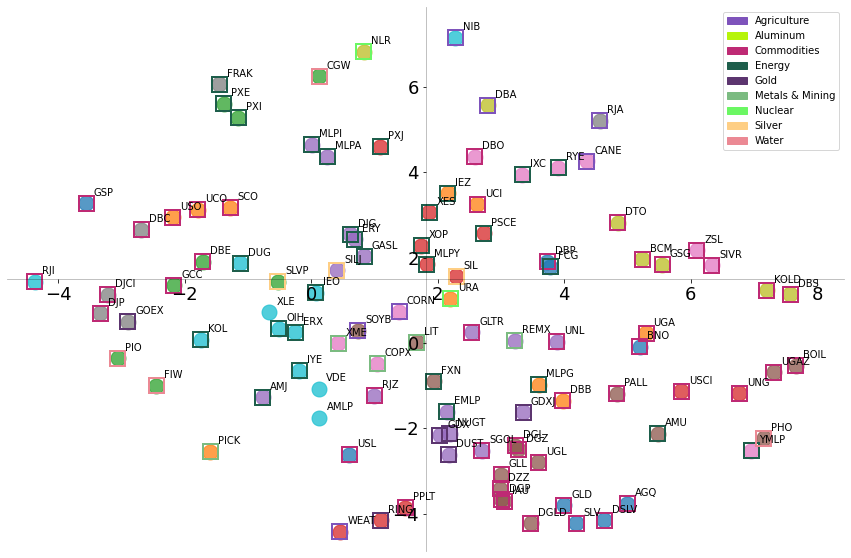

In [33]:
singular_spectral_algo_args_template = kmeans_algo_args_template.copy()
singular_spectral_algo_args_template['n_clusters'] = [40]

km_clustered_series_all, km_clustered_series, km_counts, assigned_labels = series_analyser.apply_clustering_algo('kmeans', pre_train_clusterable_feature_df,
                                                                                                        df_train_returns.columns, 
                                                                                                        permute_params(singular_spectral_algo_args_template)[0])


kmeans_augmented_feature_df = flat_dim_data_df.copy()

kmeans_augmented_feature_df['target'] = assigned_labels

sns.pairplot(kmeans_augmented_feature_df, hue='target', palette='viridis', height=5)

plt.show()

plot_clusterings(flat_dim_data_df, etfs_unique, assigned_labels)

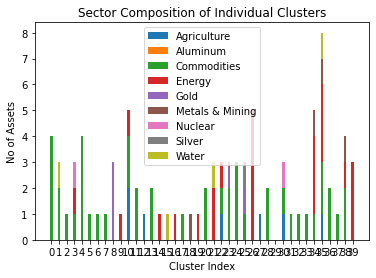

In [18]:
plot_stacked_bar_chart(km_clustered_series, etfs_unique)

In [19]:
clustering_labels = assigned_labels

for label_n in np.unique(clustering_labels):
    elements_cluster_n = list(pre_train_clusterable_feature_df[clustering_labels == label_n].index)
    
    if len(elements_cluster_n) != 1:
        etfs_cluster_n = etfs_unique[etfs_unique['Ticker'].isin(elements_cluster_n)]
        print('\nCluster {}:\n{}'.format(label_n, etfs_cluster_n[['Ticker', 'Segment']]))


Cluster 0:
   Ticker                                        Segment
46    AGQ  Leveraged Commodities: Precious Metals Silver
40   SIVR            Commodities: Precious Metals Silver
24    SLV            Commodities: Precious Metals Silver
84    ZSL    Inverse Commodities: Precious Metals Silver

Cluster 1:
    Ticker                    Segment
375    CGW       Equity: Global Water
28     GSG  Commodities: Broad Market
65     UCI  Commodities: Broad Market

Cluster 3:
    Ticker                                          Segment
48     DBB                   Commodities: Industrial Metals
277    NLR                    Equity: Global Nuclear Energy
147    XOP  Equity: U.S. Oil & Gas Exploration & Production

Cluster 4:
    Ticker                                    Segment
59     DGL          Commodities: Precious Metals Gold
89    DGLD  Inverse Commodities: Precious Metals Gold
101    DGZ  Inverse Commodities: Precious Metals Gold
90     DZZ  Inverse Commodities: Precious Metals Gold

Clus